# 백본 네트워크 구조 상세 분석

## 1. ResNet
* Residual Block이라는 아주 간단하면서 획기적인 개념을 도입해 딥러닝 모델의 레이어가 깊어져도 안정적으로 학습되면서 모델 성능 개선까지 가능함을 입증한 논문
* Abstract와 1.Introduction에서 문제의식과 이를 해결하는 솔루션의 전체적 개요를 요약해서 제시한 후 2.Related Work에서는 본 논문의 솔루션과 유사한 다른 시도들을 언급함. 3.Deep Residual Learning에는 제안 방법의 구체적인 내용과 구현 방법을 소개하고 4.Experiments에서 비교실험 구조와 다양한 데이터셋에서의 실험결과를 통해 이를 검증하는 4단계 논리 구조로 제시되고있음.

### (1) 문제 제기
* 딥러닝 모델의 Layer를 깊이 쌓으면 성능이 향상되는가?
  * Vanishing/Exploding Gradient 문제가 발생해 모델의 수렴을 방해하는 문제 발생
  * 하지만 몇 가지 대응 방법이 있다.

* Degradation Problem : Vanishing/Exploding Gradient 문제와 달리 Layer를 깊이 쌓았을 때 모델이 수렴하고 있음에도 발생하는 문제
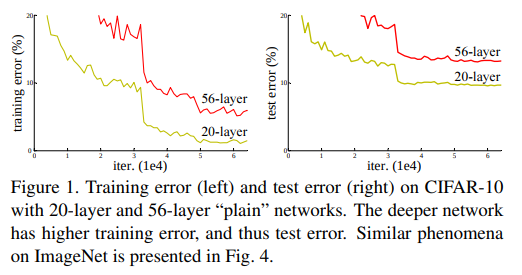
  * Degradation Problem이란 오버피팅 때문이 아닌 네트워크 구조상 레이어를 깊이 쌓았을 때 최적화가 잘 안되어 발생하는 문제로 레이어의 개수가 적을 때보다 모델의 training/test error가 더 커지는 현상을 의미한다. 
  * Normalized initialization, Intermediate normalization layers와 같은 대응 방법 존재
    
### (2) 문제에 대한 Solution - Residual Block
* 깊은 네트워크의 학습이 어려운 점을 해결하기 위해 레이어의 입력값을 활용해 Layer가 'Residual function(잔차 함수)'을 학습하도록 함
* 이는 일종의 지름길(Shortcut Connection)을 통해 레이어가 입력값을 직접 참조하도록 Layer를 변경한 것
* Shortcut Connection은 앞에서 입력으로 들어온 값을 네트워크 출력층에 곧바로 더해준다. 네트워크 출력 값에서 원본 입력값을 제외한 잔차(Residual)함수를 학습하기 때문에 네트워크가 ResNet이라는 이름을 가지게 된다.
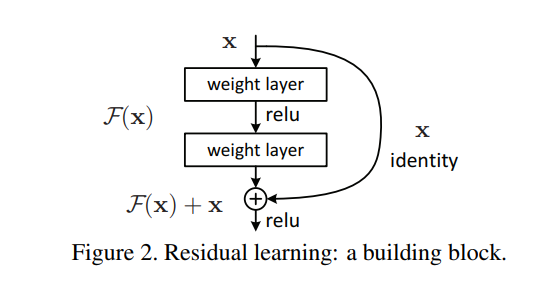
* 학습해야 할 레이어 H(x)를 F(x) + x로 만든다. x는 Layer의 입력 값이다. F(x)가 Vanishing Gradient 현상으로 학습이 안되어 Zero mapping이 되어도 최종 H(x)는 최소한 identity mapping이라도 될테니 성능 저하는 발생하지 않게 된다는 논리
* 실제로 학습해야 할 F(x)는 학습해야 할 레이어 H(x)에 입력값 x를 뺀 형태인 잔차(Residual)함수가 되는데 이는 Layer를 깊이 쌓을수록 Residual에 해당하는 F(x)는 0에 가까운 작은 값으로 수렴해도 충분하기 때문에 H(x)를 직접 학습하는 것 보다 학습이 쉬움
* 이후 Residual Layer는 F(x) + x가 되며 이 값은 ReLU를 거치게 된다.
* ResNet에서는 Shortcut Connection을 가진 ResNet의 기본 블록을 Residual Block이라고 부른다. ResNet은 이런 Residual Block 여러 개로 이루어져 있다.

## 2. DenseNet
* Densely Connected Convolution Networks
* DenseNet의 기본 블록은 L 개의 Layer가 있을 때 Layer 간 L(L+1)/2개의 직접적인 연결(direct connection)을 만듦
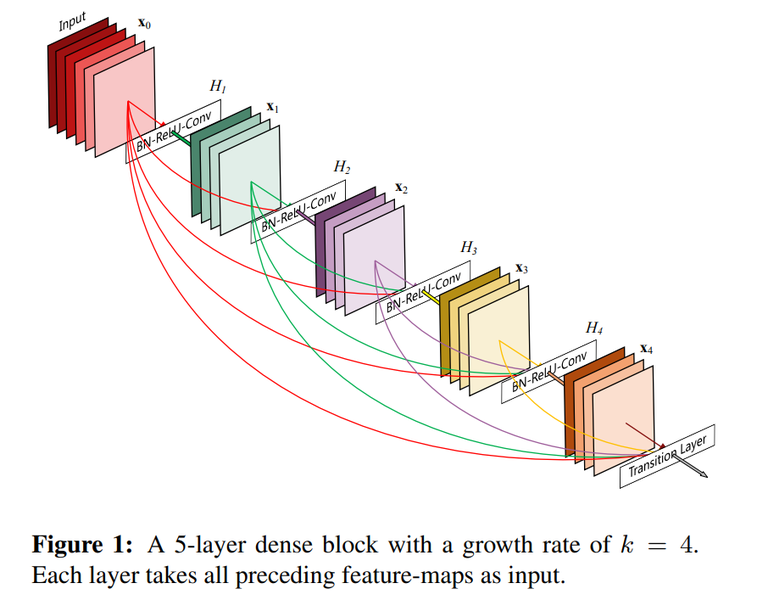
* 이런 연결을 "Dense Connectivity"라고 한다.
* 각 Layer는 이전 레이어들에서 나온 특성 맵(Feature map) 전부를 입력값으로 받고 0번째 Layer를 거친 특성 맵부터 l-1번째 Layer를 거친 특성 맵들은 합성 함수 H를 거쳐 l번째 Layer의 출력값이 된다.
* DenseNet은 이를 통해 Gradient Vanishing 문제를 개선하고 특성을 계속 재사용할 수 있게 한다.
* ResNet은 Shortcut을 원소별로 단순히 더했지만 DenseNet은 하나하나의 차원으로 쌓아(Concatenate) 하나의 텐서로 만들어 냈다.
* 합성함수는 이 텐서에 대해 배치 정규화, ReLU 활성화 함수, 3X3 컨볼루션 레이어를 통해 Pre-Activation을 수행한다.

### (1) Growth Rate
* 입력값의 채널이 4로 시작해도 Layer를 지나면서 특성 맵의 크기가 매우 커진다. 이를 제한하기 위해 Growth Rate라는 값을 조정하여 Layer를 거치면서 증가하게 되는 채널의 개수를 조절한다.
* 해당 논문에서는 CNN 채널 수를 4로 정했는데 이 값이 Growth Rate라고 할 수 있다.

In [1]:
# 입력값으로 사용되는 이미지넷 데이터에 3개의 채널
# Dense Block 내에 12개의 컨볼루션 레이어가 있을 때
# 각 레이어에서 입력받는 채널의 갯수 구하기

# Dense Block 내의 각 레이어 output의 channel을 계산하는 합수
def get_channel_list():
    channel_list = []
    input_channel = 32
    growth_rate = 32
    for i in range(12):
        channel_list.append(input_channel + growth_rate * i)
        
    return channel_list

get_channel_list()

[32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384]

## 3. SENet
* Squeeze-and-Excitation Networks
* 일반적인 CNN은 입력에 대해 컨볼루션 필터를 필터 사이즈에 따라 적용하는데 이 때 개수가 컨볼루션 레이어 출력값의 채널 개수가 된다. Squeezenet에선 채널 방향으로 global average pooling을 적용하고 압축된 정보를 활용해 중요한 채널이 활성화되도록 한다.

### (1) Squeeze
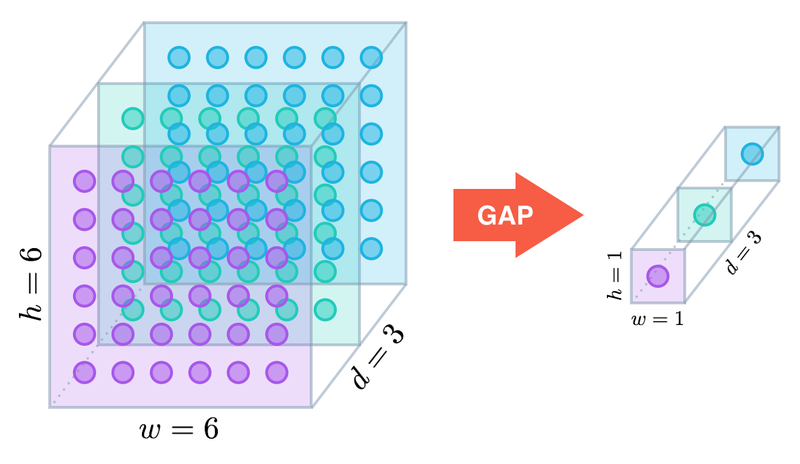
* 특성에서 중요한 정보를 짜내는 과정.
* pooling 기법을 사용하여 채널별 정보를 압축한다.

### (2) Excitate
* 채널 별 정보에 따라 어떤 채널을 강조할지 판단.
* 채널을 강조하는 것을 논문에서는 "excitation"으로 표현함.
* 하나의 채널 뿐만 아니라 여러 채널들이 서로 다른 정도로 활성화되도록 하기 위해 시그모이드를 사용함.
* 계산된 벡터를 기존의 특성 맵의 채널에 따라 곱해줘서 중요한 채널이 활성화되도록 한다.

## 4. NAS
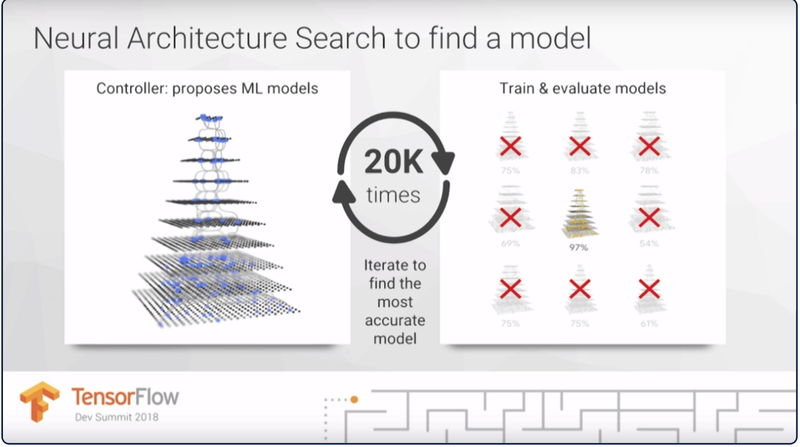
* Neural Architecture Search
* 여러가지 네트워크 구조를 탐색하는 것을 아키텍쳐 탐색이라고 하는데 그 중 신경망을 사용해 모델의 구조를 탐색하는 방법을 NAS(Neural Architecture Search)라고 한다.
* NASNet은 NAS에 강화학습을 적용해 500개의 GPU로 최적화한 CNN 모델들이다.
* 딥러닝에서 모델을 탐색하기 위해 강화학습 모델이 대상 신경망의 구성(하이퍼파라미터)을 조정하면서 최적의 성능을 내도록 하는 방법이 제안되었으며 그 중 하나가 NASNet이다.
* 아키텍쳐 탐색을 하는 동안 강화학습 모델은 대상 신경망의 구성을 일종의 변수로 조정하면서 최적의 성능을 낸다.
* 레이어의 세부 구성, CNN의 필터 크기, 채널의 개수, Connection 등이 조정할 수 있는 변수가 되며 이런 네트워크 구성에 대한 요소들을 조합할 수 있는 범위를 탐색 공간(search space)라고 한다.

### (1) Convolution cell 
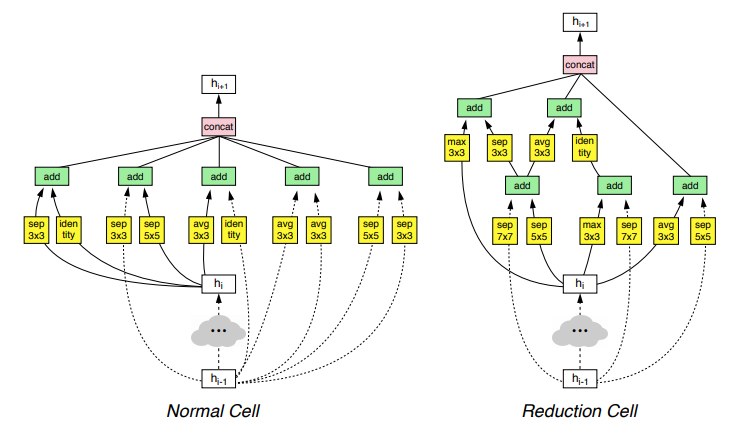
* 탐색공간을 줄이기 위해 모듈(cell)단위의 최적화를 하고 그 모듈을 조합하는 방식을 채택한다.
* ResNet에는 Residual Block, DenseNet에는 Dense Block이라는 모듈이 사용되는데, 논문에서는 이와 유사한 개념을 Convolution cell이라고 한다.
* Convolution cell은 normal cell과 reduction cell로 구분한다.
* Normal cell은 특성 맵의 가로, 세로가 유지되도록 stride를 1로 고정한다.
* Reduction cell은 stride를 1 또는 2로 가져가서 특성 맵의 크기가 줄어들 수 있도록 한다.
* 두 가지 cell을 조합한 것이 최종 결과 네트워크(NASNet)를 만들었으며, 좀 더 적은 연산과 가중치로 SOTA(State of the art) 성능을 기록했다.

## 5. EfficientNet
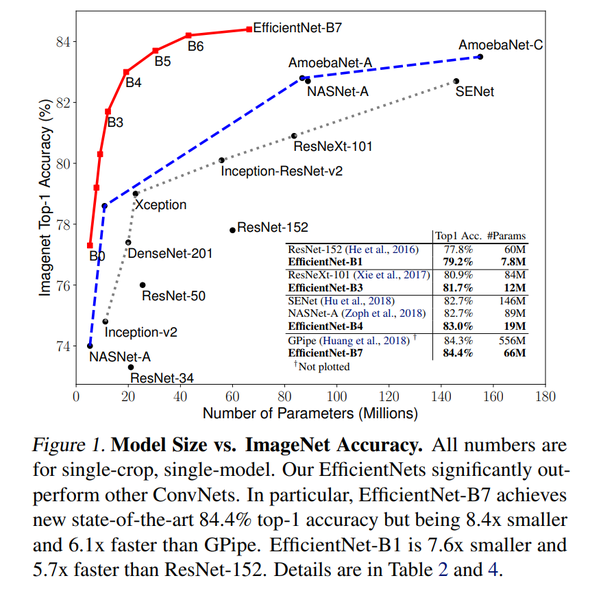
* 기존 모델들의 오류율을 뛰어넘을 뿐 아니라 모델의 크기 또한 최적화되어있다.
* 정확도를 얻기 위해 엄청난 수의 파라미터를 사용한 다른 모델들과는 달리 작고 효율적인 네트워크를 사용한다.
* 이미지에 주로 사용하는 CNN을 효율적으로 사용할 수 있도록 네트워크의 형태를 조정할 수 있는 width, depth, resolution 세 가지 요소에 집중했다.
* width는 CNN의 채널에 해당하며 채널을 늘릴수록 CNN의 파라미터와 특성을 표현하는 차원의 크기를 키울 수 있다.
* depth는 네트워크의 깊이이다.
* resolution은 입력값의 너비(w)와 높이(h) 크기이다. 입력이 클 수록 정보가 많아져 성능이 올라갈 여지가 있지만 레이어 사이의 특성 맵이 커지는 단점은 있다.

### (1) Compound  scaling
* EfficientNet은 앞서 말한 resolution, depth, width를 최적으로 조정하기 위해 앞선 NAS와 유사한 방법을 사용해 기본 모델(baseline network)의 구조를 미리 찾고 고정해 둔다.
* 모델의 구조가 고정이 되면 효율적인 모델을 찾는다는 커다란 문제가, 개별 레이어의 resolution, depth, width를 조절해 기본 모델을 적절히 확장시키는 문제로 단순화된다.
* EfficientNet 논문에서는 resolution, depth, width 라는 세 가지 'Scaling factor'를 동시에 고려하는 compound scaling을 제안한다.